### Importing Libraries

In [26]:
import os 
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm #For progress bar
import torch.nn.functional as F

### Root Data Directory Path

In [2]:
data_dir = r"C:\Users\priya\PycharmProjects\SIgnature Recognition/notebook/data"

### Total number of classes

In [3]:
class_name =os.listdir(data_dir)
len(class_name)

2

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms as T, datasets

### Checking cuda availability

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:{}".format(device))

Device:cuda


### Transforming the data

In [6]:
data_transform = T.Compose([
                             T.Resize(size=(224,224)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image augmentation for each epoch
                             T.ToTensor(), #Converting the dimension from (height,width,channel) to (channel,height,width) convension of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) #Normalize by 3 means 3 StD's of the image net,3 channels
])

In [7]:
data = datasets.ImageFolder(data_dir,transform= data_transform)
total_count = len(data)

In [8]:
total_count

2640

In [9]:
data.classes

['Forged', 'Original']

### Splitting the data 

In [10]:
train_count = int(0.6*total_count)
valid_count = int(0.3*total_count)
test_count = total_count - train_count - valid_count
train_data, val_data, test_data = torch.utils.data.random_split(data,(train_count,valid_count,test_count))

In [11]:
train_data.dataset

Dataset ImageFolder
    Number of datapoints: 2640
    Root location: C:\Users\priya\PycharmProjects\SIgnature Recognition/notebook/data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [12]:
len(train_data.indices)

1584

In [13]:
len(test_data.indices)

264

In [14]:
len(val_data.indices)

792

# Functions for visualization

In [15]:
def show_image(image, label, get_denormalize=True):
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    if get_denormalize == True:
        image = image * std + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(label)
    else:
        plt.imshow(image)
        plt.title(label)

def show_grid(image, title=None):
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    image = image * std + mean
    image = np.clip(image, 0, 1)

    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title is not None:
        plt.title(title)

def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim=1)
    top_p, top_class = y_pred.topk(1,dim=1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

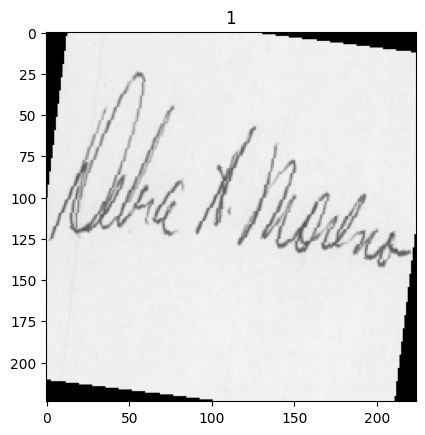

In [16]:
img, label = train_data[0]
show_image(img, label)

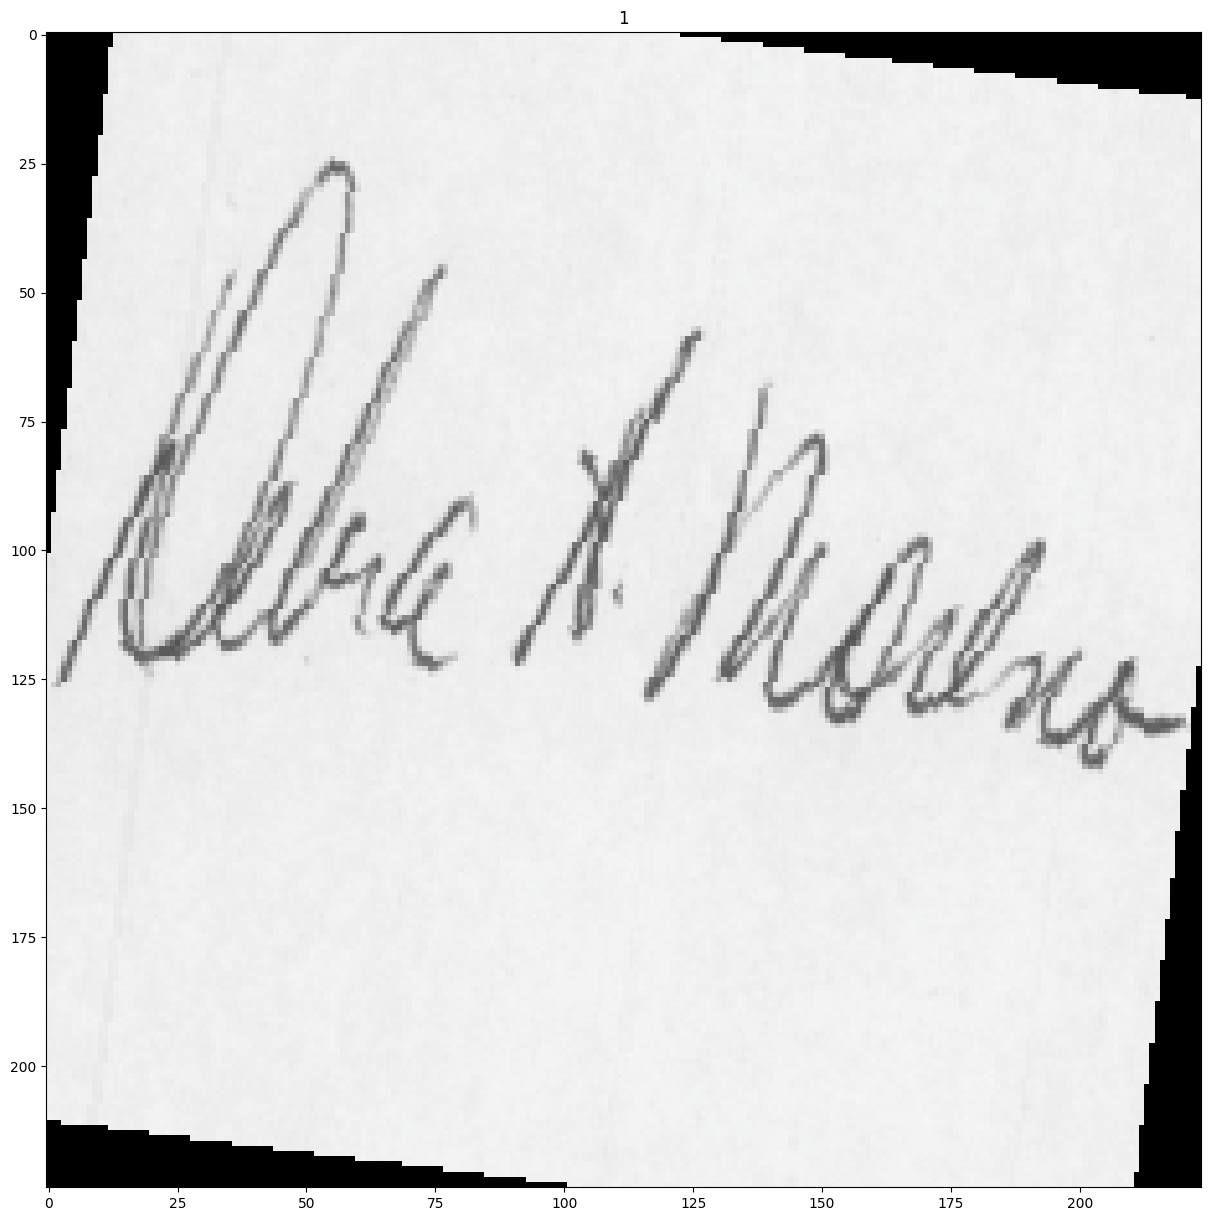

In [17]:
show_grid(img, label)

### Data Loaders (will be passed to the model)

In [18]:
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader)))
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = DataLoader(val_data, batch_size=32, shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader)))
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = DataLoader(test_data, batch_size=32, shuffle=False)
print("No. of batches in testloader:{}".format(len(testloader)))
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:50
No. of Total examples:1584
No. of batches in validationloader:25
No. of Total examples:792
No. of batches in testloader:9
No. of Total examples:264


### Using ResNet34(transfer learning technique)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms

In [20]:
model = models.resnet34(pretrained=True)

C:\Users\priya\anaconda3\envs\signatureRecognition\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\priya\anaconda3\envs\signatureRecognition\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
print(model) #To get model's architecture

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Changing last layer of resnet34 as it is trained on 90 classes but we have only two

In [24]:
# Access the original fully connected layer
original_fc = model.fc
# Determine the number of input features
original_in_features = original_fc.in_features
# Replace the fully connected layer
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(original_in_features, len(class_name))
)
model = model.to(device)
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [27]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader):
    total_train_loss = 0
    total_test_loss = 0

    model.train()
    with tqdm(train_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'training')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True) #Image will be converted wrt device
            idxs = idxs.to(device, non_blocking=True)
            output = model(images)

            loss = criterion(output, idxs)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

    model.eval()
    #Testing part
    with tqdm(test_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'testing')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)

            output = model(images)
            loss = criterion(output, idxs)
            total_test_loss += loss.item()

    train_acc = total_train_loss/len(train_data)
    test_acc = total_test_loss/len(val_data)
    print(f'Train loss: {train_acc:.4f} Test loss: {test_acc:.4f} ')

In [28]:
%%time
epochs = 2 
for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    train(model,criterion,optimizer,trainloader,validationloader)

Epoch 1/2


Train loss: 0.0080 Test loss: 0.0116 
Epoch 2/2


Train loss: 0.0005 Test loss: 0.0001 
CPU times: total: 3min 17s
Wall time: 2min 53s


### Saving the model

In [29]:
pwd

'C:\\Users\\priya\\PycharmProjects\\SIgnature Recognition\\notebook'

In [30]:
Path = r'C:\\Users\\priya\\PycharmProjects\\SIgnature Recognition\\notebook\\model.pt'

In [31]:
torch.save(model, Path)

### Loading torch model

In [32]:
#Model class must be defined somewhere
model = torch.load(Path)
model.eval()

C:\Users\priya\AppData\Local\Temp\ipykernel_18420\3444760222.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(Path)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Model Evaluation

In [37]:
def evaluate(model, criterion, optimizer, test_dataloader):
    total_test_loss = 0
    model.eval()
    with tqdm(test_dataloader,unit='batch',leave=False) as pbar:
        pbar.set_description(f'testing')
        for images,idxs in pbar:
            images = images.to(device,non_blocking=True)
            idxs = idxs.to(device,non_blocking=True)
            output = model(images)
            loss = criterion(output,idxs)
            total_test_loss += loss.item()

    test_acc = total_test_loss/len(val_data)
    print(f'Test loss: {test_acc: .4f}')

In [38]:
evaluate(model,criterion,optimizer,testloader)

Test loss:  0.0001


### Prediction

In [39]:
label_names = data.classes
label_names

['Forged', 'Original']

In [42]:
from PIL import Image

# Load the image and preprocess it
image = Image.open(r'C:\Users\priya\PycharmProjects\SIgnature Recognition\notebook\data\Original\original_1_18.png')
preprocess = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.Grayscale(3),
    transforms.ToTensor()
])

image = preprocess(image)
image = image[:3]

# Convert the image to a PyTorch tensor and send it to the device
image = image.unsqueeze(0).to(device)

# Make the prediction
with torch.no_grad():
    logits = model(image)
    probs = torch.softmax(logits, dim=1)
    pred_label = torch.argmax(probs, dim=1)

# Print the prediction
print(f'Predicted label: {pred_label.item()}')

# Map the predicted label to the corresponding class name
predicted_class_name = label_names[pred_label.item()]

# Print the predicted class name
print(f'Predicted class name: {predicted_class_name}')

Predicted label: 1
Predicted class name: Original
